In [0]:
from google.colab.patches import cv2_imshow
import os
import pathlib
import cv2
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd

TensorFlow 2.x selected.


In [0]:
new_dir_train = '/content/drive/My Drive/Datasets/kdef_akdef/KDEF_front(bw)(with train-test-val split)/train'
new_dir_test = '/content/drive/My Drive/Datasets/kdef_akdef/KDEF_front(bw)(with train-test-val split)/test'
new_dir_val = '/content/drive/My Drive/Datasets/kdef_akdef/KDEF_front(bw)(with train-test-val split)/val'

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      horizontal_flip=True,
      #fill_mode='nearest'
      )

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = train_datagen.flow_from_directory(
        new_dir_train,  # This is the source directory for training images
        target_size=(200,200),
        batch_size=66,
        color_mode = 'grayscale',          
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        new_dir_val,  # This is the source directory for training images
        target_size=(200,200),  
        batch_size=20,
        color_mode = 'grayscale',
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        new_dir_test,  # This is the source directory for training images
        target_size=(200,200),  
        batch_size=10,
        color_mode = 'grayscale',
        class_mode='categorical')

Found 660 images belonging to 7 classes.
Found 140 images belonging to 7 classes.
Found 149 images belonging to 7 classes.


In [0]:
inputs = tf.keras.layers.Input(shape=(200,200, 1))
x = tf.keras.layers.Conv2D(64, 7, strides = 2, padding='valid')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
x = tf.keras.layers.LayerNormalization()(x)
#parallel featext block1
#path1
x_1 = tf.keras.layers.Conv2D(96, 1, strides = 1, padding='same')(x)
x_1 = tf.keras.layers.Activation('relu')(x_1)

x_1 = tf.keras.layers.Conv2D(208, 3, strides = 1, padding='valid')(x_1)
x_1 = tf.keras.layers.Activation('relu')(x_1)
#path2
x_2 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='valid')(x)
x_2 = tf.keras.layers.Conv2D(64, 1, strides = 1, padding='same')(x_2)
#concatenate
x_3 = tf.keras.layers.Concatenate(axis = 3)([x_1, x_2])
x_3 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x_3)

#parallel featext block2
#path1
x_4 = tf.keras.layers.Conv2D(96, 1, strides = 1, padding='same')(x_3)
x_4 = tf.keras.layers.Activation('relu')(x_4)

x_4 = tf.keras.layers.Conv2D(208, 3, strides = 1, padding='valid')(x_4)
x_4 = tf.keras.layers.Activation('relu')(x_4)

#path2
x_5 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='valid')(x_3)
x_5 = tf.keras.layers.Conv2D(64, 1, strides = 1, padding='same')(x_5)

#concatenate
x_6 = tf.keras.layers.Concatenate(axis = 3)([x_4, x_5])
x_6 = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x_6)

x_7 = tf.keras.layers.Flatten()(x_6)
x_7 = tf.keras.layers.Dropout(0.25)(x_7)
x_7 = tf.keras.layers.Dense(7)(x_7)
x_8 = tf.keras.layers.Activation('softmax')(x_7)

In [0]:
model = tf.keras.models.Model(inputs = inputs , outputs = x_8)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 97, 97, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 97, 97, 64)   0           conv2d_34[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 49, 49, 64)   0           activation[0][0]                 
______________________________________________________________________________________________

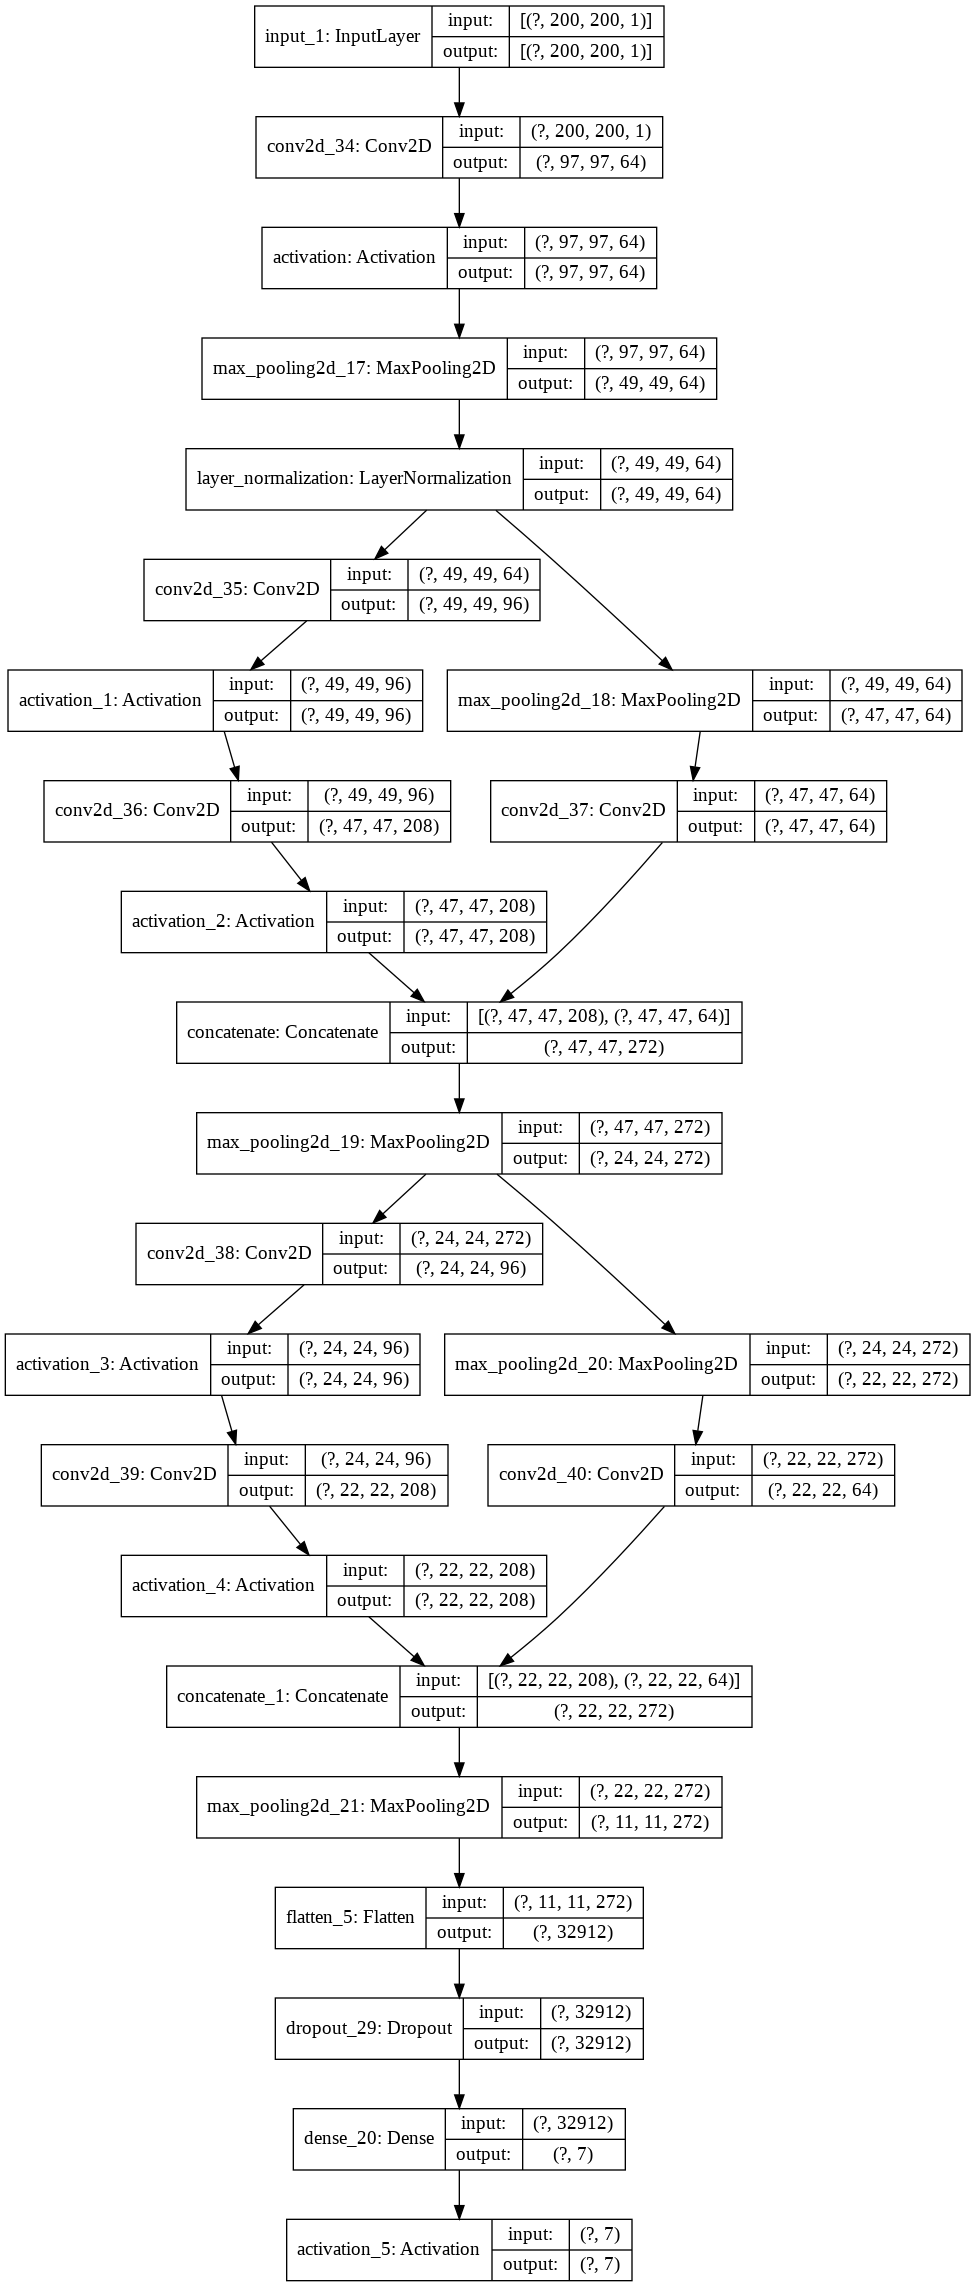

In [0]:
tf.keras.utils.plot_model(model, to_file='model_dex_kd_bw.png', show_shapes=True, show_layer_names=True)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
lr_reducer_d = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)

tensorboard_d = tf.keras.callbacks.TensorBoard(log_dir='./logs')

early_stopper_d = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

checkpointer_d = tf.keras.callbacks.ModelCheckpoint('model_dex_kd_bw.h5', monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
history = model.fit(train_generator,
    steps_per_epoch=int(660/66),
    epochs = 150,
    shuffle=True, 
    validation_data=validation_generator,
    validation_steps=int(140/20),
    callbacks=[lr_reducer_d, tensorboard_d, early_stopper_d, checkpointer_d]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 7 steps
Epoch 1/150
 9/10 [==========================>...] - ETA: 0s - loss: 3.0724 - accuracy: 0.1431
Epoch 00001: val_loss improved from inf to 2.02168, saving model to model_dex_kd_bw.h5
10/10 [==============================] - 6s 632ms/step - loss: 2.9727 - accuracy: 0.1394 - val_loss: 2.0217 - val_accuracy: 0.1857
Epoch 2/150
 9/10 [==========================>...] - ETA: 0s - loss: 2.0916 - accuracy: 0.1886
Epoch 00002: val_loss improved from 2.02168 to 1.90237, saving model to model_dex_kd_bw.h5
10/10 [==============================] - 3s 345ms/step - loss: 2.0827 - accuracy: 0.1894 - val_loss: 1.9024 - val_accuracy: 0.2643
Epoch 3/150
 9/10 [==========================>...] - ETA: 0s - loss: 1.9449 - accuracy: 0.1835
Epoch 00003: val_loss did not improve from 1.90237
10/10 [==============================] - 3s 339ms/step - loss: 1.9362 - accuracy: 0.1848 - val_loss: 1.9815 - val_accuracy: 0.1500
Ep

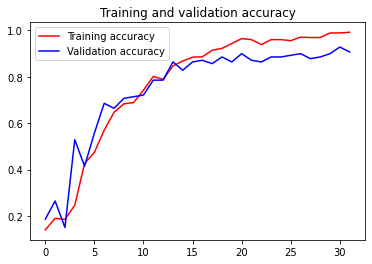

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

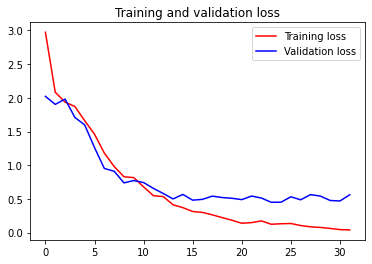

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [0]:
score=model.evaluate(test_generator,verbose=1)

  ...
    to  
  ['...']
15/15 [==============================] - 135s 9s/step - loss: 0.4504 - accuracy: 0.8591


In [0]:
def detect_face(image):
  cascPath = '/content/drive/My Drive/BE Project/sarvesh/haarcascades/haarcascade_frontalface_default.xml'
  faceCascade = cv2.CascadeClassifier(cascPath)
  #BGR to gray conversion
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #Cascade multiscale classifier
  detected_faces = faceCascade.detectMultiScale(image, minNeighbors=3,
                                                minSize=(10,10)
  )
  sub = gray

  for x, y, w, h in detected_faces:
    #if w>100:
      sub = gray[y:y+h,x:x+w]
  return sub,detected_faces

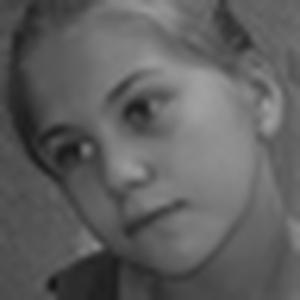

In [0]:
image = cv2.imread('/content/drive/My Drive/Datasets/FER2013 (images)/val_images/sad/1_sa.jpg',1)
cv2_imshow(image)

In [0]:
image.shape

(300, 300, 3)

In [0]:
sub_img,detected_face = detect_face(image)
print(detected_face)

()


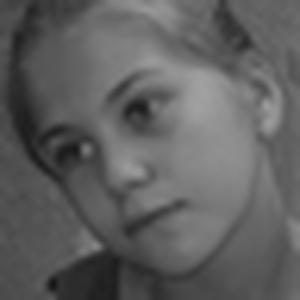

In [0]:
cv2_imshow(sub_img)

In [0]:
sub_img.shape

(300, 300)

In [0]:
sub_img = cv2.resize(sub_img, (200,200), interpolation = cv2.INTER_AREA)

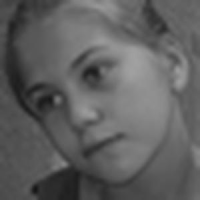

In [0]:
cv2_imshow(sub_img)

In [0]:
sub_img.shape

(200, 200)

In [0]:
sub_img = np.reshape(sub_img, (1,200,200,1))

In [0]:
sub_img.shape

(1, 200, 200, 1)

In [0]:
pred_array = model.predict(sub_img)
prediction = np.argmax(pred_array)
print(pred_array)
print(prediction)
if (prediction == 0):
  print('angry')
elif (prediction == 1):
  print('disgust')
elif (prediction == 2):
  print('fear')
elif (prediction == 3):
  print('happiness')
elif (prediction == 4):
  print('neutral')
elif (prediction == 5):
  print('sadness')
elif (prediction == 6):
  print('surprise')

[[8.5121810e-01 8.3321083e-07 3.1237831e-04 9.2109326e-10 1.6768222e-07
  1.4846858e-01 1.5801387e-10]]
0
angry


1